<a href="https://colab.research.google.com/github/dp1500/Algorithmic-Trading/blob/main/Rsi%20fro%20aapl%20day%20trades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Load data
df = pd.read_csv('HistoricalQuotes.csv')


In [5]:
print(df["Close"].dtype)

float64


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index(ascending=True)

In [7]:
df

,Close,Volume,Open,High,Low
Date,,,,,
2010-03-01,29.86,137312041,29.3928,29.9286,29.3500
2010-03-02,29.84,141486282,29.9900,30.1186,29.6771
2010-03-03,29.90,92846488,29.8486,29.9814,29.7057
2010-03-04,30.10,89591907,29.8971,30.1314,29.8043
2010-03-05,31.28,224647427,30.7057,31.3857,30.6614
...,...,...,...,...,...
2020-02-24,298.18,55548830,297.2600,304.1800,289.2300
2020-02-25,288.08,57668360,300.9500,302.5300,286.1300
2020-02-26,292.65,49678430,286.5300,297.8800,286.5000


In [8]:
df.columns

Index(['Close', ' Volume', 'Open', 'High', 'Low'], dtype='object')

In [9]:
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df[' Volume'] = pd.to_numeric(df[' Volume'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')


In [10]:
print(df["Close"].dtype)

float64


In [11]:
print(df.head())
print(df['Close'].dtype)

            Close     Volume     Open     High      Low
Date                                                   
2010-03-01  29.86  137312041  29.3928  29.9286  29.3500
2010-03-02  29.84  141486282  29.9900  30.1186  29.6771
2010-03-03  29.90   92846488  29.8486  29.9814  29.7057
2010-03-04  30.10   89591907  29.8971  30.1314  29.8043
2010-03-05  31.28  224647427  30.7057  31.3857  30.6614
float64


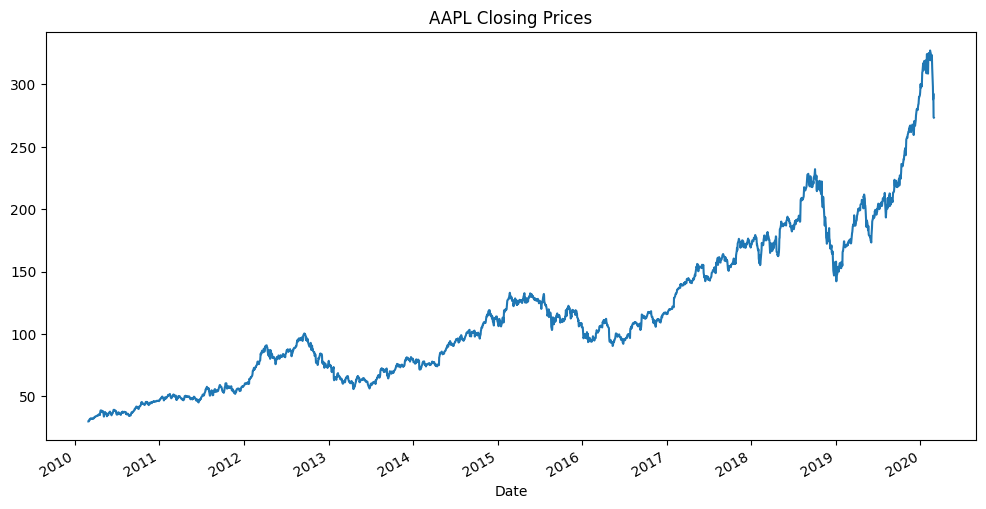

In [12]:
# Plot closing prices
df['Close'].plot(figsize=(12,6))
plt.title('AAPL Closing Prices')
plt.show()

## Implement RSI

In [13]:
# creating dataframes copies to fing optimum average periods
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()
df4 = df.copy()

In [27]:

def compute_rsi(data, window):
    """Compute the RSI (Relative Strength Index) for a given data series."""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def rsi_strategy(df):
    df['RSI'] = compute_rsi(df['Close'], 14)

    # Define signal thresholds
    df['Signal'] = 0  # Default to no action
    df.loc[df['RSI'] < 40, 'Signal'] = 1  # Buy when RSI is below 30
    df.loc[df['RSI'] > 60, 'Signal'] = -1  # Sell when RSI is above 70

    return df


In [28]:
df = rsi_strategy(df)
df.head()

,Close,Volume,Open,High,Low,RSI,Signal,Daily_Return,Strategy_Return
Date,,,,,,,,,
2010-03-01,29.86,137312041,29.3928,29.9286,29.3500,NaN,0,NaN,NaN
2010-03-02,29.84,141486282,29.9900,30.1186,29.6771,NaN,0,-0.000670,-0.0
2010-03-03,29.90,92846488,29.8486,29.9814,29.7057,NaN,0,0.002011,0.0
2010-03-04,30.10,89591907,29.8971,30.1314,29.8043,NaN,0,0.006689,0.0
2010-03-05,31.28,224647427,30.7057,31.3857,30.6614,NaN,0,0.039203,0.0


## Implement and Backtest the Strategy

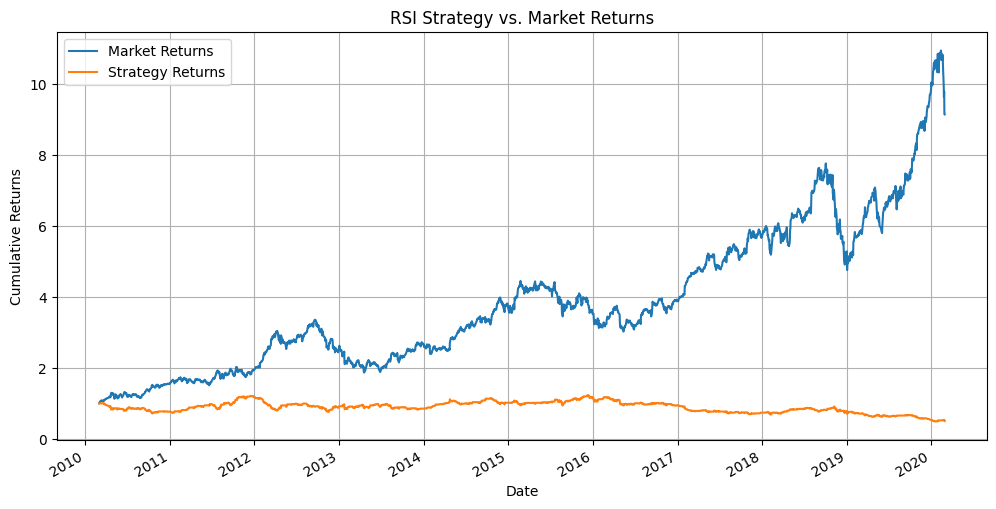

In [29]:
# Calculate daily strategy returns
df['Daily_Return'] = df['Close'].pct_change()
df['Strategy_Return'] = df['Signal'].shift(1) * df['Daily_Return']

# Calculate cumulative returns for both the strategy and the stock
cumulative_strategy_returns = (df['Strategy_Return'] + 1).cumprod()
cumulative_market_returns = (df['Daily_Return'] + 1).cumprod()

# Plot the results for a visual comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
cumulative_market_returns.plot(label='Market Returns', legend=True)
cumulative_strategy_returns.plot(label='Strategy Returns', legend=True)
plt.title('RSI Strategy vs. Market Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



## metrics

In [30]:
cumulative_strategy_returns = (df['Strategy_Return'] + 1).cumprod()
cumulative_market_returns = (df['Daily_Return'] + 1).cumprod()

final_cumulative_strategy_return = cumulative_strategy_returns.iloc[-1] - 1
final_cumulative_market_return = cumulative_market_returns.iloc[-1] - 1

print(f"Final Cumulative Strategy Return: {final_cumulative_strategy_return:.2%}")
print(f"Final Cumulative Market Return: {final_cumulative_market_return:.2%}")



Final Cumulative Strategy Return: -49.99%
Final Cumulative Market Return: 815.47%


In [31]:
# import pandas as pd
from scipy.stats import skew, kurtosis

def print_strategy_metrics(df):
    # Max Drawdown
    def max_drawdown(returns_series):
        cumulative_returns = (1 + returns_series).cumprod()
        rolling_max = cumulative_returns.cummax()
        drawdowns = (cumulative_returns - rolling_max) / rolling_max
        return drawdowns.min()

    # Cumulative Returns
    final_cumulative_strategy_return = (df['Strategy_Return'] + 1).cumprod().iloc[-1] - 1
    final_cumulative_market_return = (df['Daily_Return'] + 1).cumprod().iloc[-1] - 1

    # Annualized Returns
    annualized_strategy_return = (1 + df['Strategy_Return'].mean())**252 - 1
    annualized_market_return = (1 + df['Daily_Return'].mean())**252 - 1

    # Annualized Volatility
    annualized_strategy_volatility = df['Strategy_Return'].std() * (252**0.5)
    annualized_market_volatility = df['Daily_Return'].std() * (252**0.5)

    # Skewness & Kurtosis
    strategy_skewness = skew(df['Strategy_Return'].dropna())
    strategy_kurtosis = kurtosis(df['Strategy_Return'].dropna())

    # VaR (95% one-day VaR)
    var_95 = df['Strategy_Return'].quantile(0.05)


    # Sharpe Ratio
    risk_free_rate = 0.0
    sharpe_ratio = (annualized_strategy_return - risk_free_rate) / annualized_strategy_volatility

    # Sortino Ratio
    downside_volatility = df[df['Strategy_Return'] < 0]['Strategy_Return'].std() * (252**0.5)
    sortino_ratio = (annualized_strategy_return - risk_free_rate) / downside_volatility

    # Beta
    cov_matrix = df[['Strategy_Return', 'Daily_Return']].cov()
    beta = cov_matrix.iloc[0, 1] / df['Daily_Return'].var()

    # Print Metrics
    print(f"Final Cumulative Strategy Return: {final_cumulative_strategy_return:.2%}")
    print(f"Final Cumulative Market Return: {final_cumulative_market_return:.2%}")
    print(f"Annualized Strategy Return: {annualized_strategy_return:.2%}")
    print(f"Annualized Market Return: {annualized_market_return:.2%}")
    print(f"Annualized Strategy Volatility: {annualized_strategy_volatility:.2%}")
    print(f"Annualized Market Volatility: {annualized_market_volatility:.2%}")
    print(f"Strategy Max Drawdown: {max_drawdown(df['Strategy_Return']):.2%}")
    print(f"Strategy Skewness: {strategy_skewness:.2f}")
    print(f"Strategy Kurtosis: {strategy_kurtosis:.2f}")
    print(f"Strategy 95% 1-day VaR: {var_95:.2%}")
    print(f"Strategy Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Strategy Sortino Ratio: {sortino_ratio:.2f}")
    print(f"Strategy Beta: {beta:.2f}")


# Call the function
print_strategy_metrics(df)


Final Cumulative Strategy Return: -49.99%
Final Cumulative Market Return: 815.47%
Annualized Strategy Return: -4.75%
Annualized Market Return: 29.06%
Annualized Strategy Volatility: 20.32%
Annualized Market Volatility: 25.83%
Strategy Max Drawdown: -60.22%
Strategy Skewness: -0.08
Strategy Kurtosis: 10.40
Strategy 95% 1-day VaR: -1.99%
Strategy Sharpe Ratio: -0.23
Strategy Sortino Ratio: -0.27
Strategy Beta: 0.07


In [32]:
df.head(50)

,Close,Volume,Open,High,Low,RSI,Signal,Daily_Return,Strategy_Return
Date,,,,,,,,,
2010-03-01,29.86,137312041,29.3928,29.9286,29.3500,NaN,0,NaN,NaN
2010-03-02,29.84,141486282,29.9900,30.1186,29.6771,NaN,0,-0.000670,-0.000000
2010-03-03,29.90,92846488,29.8486,29.9814,29.7057,NaN,0,0.002011,0.000000
2010-03-04,30.10,89591907,29.8971,30.1314,29.8043,NaN,0,0.006689,0.000000
2010-03-05,31.28,224647427,30.7057,31.3857,30.6614,NaN,0,0.039203,0.000000
2010-03-08,31.30,107326832,31.4300,31.4414,31.1786,NaN,0,0.000639,0.000000
2010-03-09,31.86,229908139,31.1871,32.1428,31.1271,NaN,0,0.017891,0.000000
2010-03-10,32.12,148907755,31.9757,32.2114,31.8857,NaN,0,0.008161,0.000000
2010-03-11,32.21,101209110,31.9871,32.2143,31.9028,NaN,0,0.002802,0.000000


In [33]:
df["Signal"].value_counts()

-1    1086
 0     942
 1     490
Name: Signal, dtype: int64